### Use the instructor's notebook [here](https://github.com/nipunbatra/ml-teaching/blob/master/notebooks/movie-recommendation-knn-mf.ipynb) on matrix factorization, and solve the following questions. Use the above image from Q4 and complete the rectangular missing patch for three cases, i.e. a rectangular block of 30X30 is assumed missing from the image. Choose rank r yourself. Vary the patch location as follows.


1. an area with mainly a single color.

In [264]:
import os
import torch

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torchvision
import matplotlib.pyplot as plt
from einops import rearrange

In [265]:
if os.path.exists("dog.jpg"):
    print('dog.jpg exists')
else:    
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg
    


dog.jpg exists


In [266]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)
# print(img)


torch.Size([3, 1365, 2048])


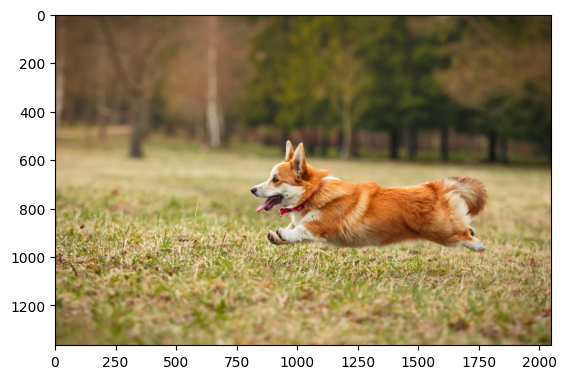

In [267]:
plt.imshow(rearrange(img,'c h w -> h w c'))

In [268]:
from sklearn import preprocessing
scaler_img=preprocessing.MinMaxScaler().fit(img.reshape(-1,1))
scaler_img

MinMaxScaler()

In [269]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape
# print(img_scaled)
img_scaled=torch.tensor(img_scaled)
img_scaled=img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [270]:
crop=torchvision.transforms.functional.crop(img_scaled.cpu(),600,800,300,300)
crop.shape

torch.Size([3, 300, 300])

torch.Size([3, 300, 300])


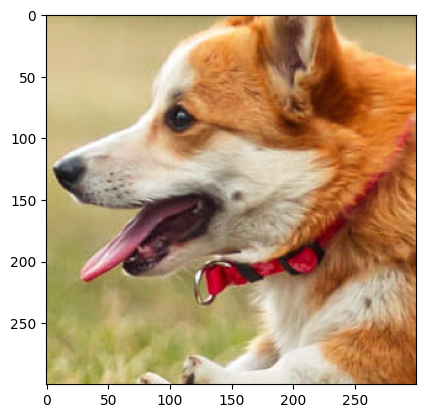

In [271]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
print(crop.shape)


In [272]:
def get_patch(image,patch_size,x_min,y_min):
    return image[:,y_min:y_min+patch_size,x_min:x_min+patch_size]

In [273]:
# Check if the standard deviation across channels is small, indicating a single color
def is_mostly_single_color(patch):
    return torch.std(patch) < 0.1


def has_multiple_channels(patch,threshold=0.1,min_channel=2):
    std_devs_per_channel=torch.std(patch,dim=(1,2))
    return (std_devs_per_channel > threshold).sum()>=min_channel

def has_at_least_n_colors(patch, min_colors=5):
    unique_colors_per_channel = [torch.unique(patch[channel, :, :]).shape[0] for channel in range(patch.shape[0])]
    # print(unique_colors_per_channel)
    # print(unique_colors_per_channel)
    return all(count >= min_colors for count in unique_colors_per_channel)

In [274]:
image=crop
image.shape

torch.Size([3, 300, 300])

In [275]:
image_shape = (3, 300, 300)
image = image
patch_size = 30
min_x = 0
max_x = image.shape[2] - patch_size
min_y = image.shape[1] - patch_size
max_y = 0
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 300 300


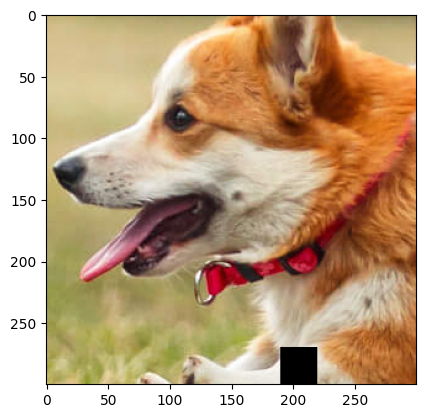

In [276]:
def get_patch(image,patch_size,x_min,y_min):
    return image[:,y_min:y_min+patch_size,x_min:x_min+patch_size]

def create_masked_matrix(original_matrix, block_size=30):
    masked_matrix = original_matrix.clone()
    min_x = 0
    max_x = image.shape[2] - patch_size
    min_y = image.shape[1] - patch_size
    max_y = 0
    # Choose the location based on color characteristics
    selected_region = None
    for y in range(original_matrix.shape[1] - block_size, 0, -10):
        for x in range(0,original_matrix.shape[2] - block_size, 10):
            # Fetch the patch
            patch = get_patch(original_matrix, block_size, x, y)

            # Check if the patch meets the condition 
            if is_mostly_single_color(patch):
                selected_region = (y, x)
                break

        if selected_region is not None:
            break

    # Update the masked matrix
    masked_matrix[:, 
                  selected_region[0]:selected_region[0]+block_size, 
                  selected_region[1]:selected_region[1]+block_size] = 0

    return masked_matrix
masked_image = create_masked_matrix(crop)
plt.imshow(rearrange(masked_image, 'c h w -> h w c').cpu().numpy())


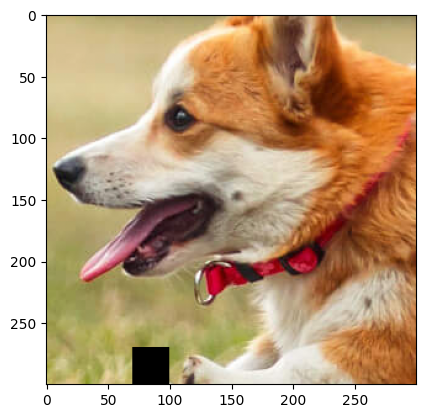

In [277]:
def create_masked_matrix(original_matrix, block_size=30):
    masked_matrix = original_matrix.clone()
    min_x = 0
    max_x = image.shape[2] - patch_size
    min_y = image.shape[1] - patch_size
    max_y = 0
    # Choose the location based on color characteristics
    selected_region = None
    for y in range(original_matrix.shape[1] - block_size, 0, -10):
        for x in range(0,original_matrix.shape[2] - block_size, 10):
            # Fetch the patch
            patch = get_patch(original_matrix, block_size, x, y)

            # Check if the patch meets the condition 
            if has_multiple_channels(patch):
                selected_region = (y, x)
                break

        if selected_region is not None:
            break

    # Update the masked matrix
    masked_matrix[:, 
                  selected_region[0]:selected_region[0]+block_size, 
                  selected_region[1]:selected_region[1]+block_size] = 0

    return masked_matrix
masked_image_two_channel = create_masked_matrix(crop)
plt.imshow(rearrange(masked_image_two_channel, 'c h w -> h w c').cpu().numpy())


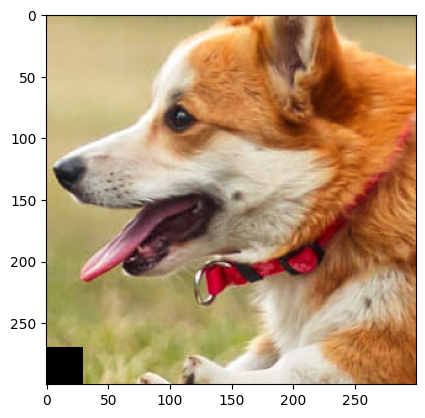

In [278]:
def get_patch(image,patch_size,x_min,y_min):
    return image[:,y_min:y_min+patch_size,x_min:x_min+patch_size]

def create_masked_matrix(original_matrix, block_size=30):
    masked_matrix = original_matrix.clone()
    min_x = 0
    max_x = image.shape[2] - patch_size
    min_y = image.shape[1] - patch_size
    max_y = 0
    # Choose the location based on color characteristics
    selected_region = None
    for y in range(original_matrix.shape[1] - block_size, 0, -10):
        for x in range(0,original_matrix.shape[2] - block_size, 10):
            # Fetch the patch
            patch = get_patch(original_matrix, block_size, x, y)

            # Check if the patch meets the condition 
            if has_at_least_n_colors(patch):
                selected_region = (y, x)
                break

        if selected_region is not None:
            break

    # Update the masked matrix
    masked_matrix[:, 
                  selected_region[0]:selected_region[0]+block_size, 
                  selected_region[1]:selected_region[1]+block_size] = 0

    return masked_matrix
masked_image_five_channel = create_masked_matrix(crop)
plt.imshow(rearrange(masked_image_five_channel, 'c h w -> h w c').cpu().numpy())


In [279]:
r = 20
W = torch.randn(crop.shape[1], r, requires_grad=True, device=device)
H = torch.randn(r, crop.shape[2], requires_grad=True, device=device)
print(W.shape, H.shape)


torch.Size([300, 20]) torch.Size([20, 300])


In [280]:
crop=crop.to(device)
masked_image=masked_image.to(device)
masked_image_five_channel=masked_image_five_channel.to(device)
masked_image_two_channel=masked_image_two_channel.to(device)
with torch.no_grad():
    loss=torch.norm(torch.mm(W, H)-masked_image)
    print(loss)

with torch.no_grad():
    loss_two=torch.norm(torch.mm(W, H)-masked_image_two_channel)
    print(loss_two)    

with torch.no_grad():
    loss_five=torch.norm(torch.mm(W, H)-masked_image_five_channel)
    print(loss_five)    

tensor(2340.8610, device='cuda:0', dtype=torch.float64)
tensor(2340.8174, device='cuda:0', dtype=torch.float64)
tensor(2340.8153, device='cuda:0', dtype=torch.float64)


In [281]:
#optimizer
learning_rate = 0.01
num_iterations = 10000
optimizer = torch.optim.Adam([W, H], lr=learning_rate)
for i in range(num_iterations):
    loss = torch.norm(torch.mm(W, H) - masked_image)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")


Iteration 0, Loss: 2340.8610067359323


Iteration 1000, Loss: 84.57288821041725
Iteration 2000, Loss: 81.75152619012127
Iteration 3000, Loss: 80.4019373435545
Iteration 4000, Loss: 79.76280834364134
Iteration 5000, Loss: 79.3353306904989
Iteration 6000, Loss: 79.17053784148344
Iteration 7000, Loss: 79.08887910413873
Iteration 8000, Loss: 79.01930298514625
Iteration 9000, Loss: 79.0167892249857


In [282]:
def plot_original_masked_reconstructed_images(original, masked_image, reconstructed, title1="Original", title2="Masked Image", title3="Reconstructed"):
    """
    Plots the original, masked, and reconstructed images side-by-side.

    Args:
        original: The original image tensor with shape (channels, height, width).
        masked_image: The masked image tensor with shape (channels, height, width).
        reconstructed: The reconstructed image tensor with shape (channels, height, width).
        title1, title2, title3: Titles for the subplots (optional).
    """

    num_channels, height, width = original.shape
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    # Plot original image
    axs[0].imshow(rearrange(original, 'c h w -> h w c').cpu().numpy())
    axs[0].set_title(title1)

    # Plot masked image
    axs[1].imshow(rearrange(masked_image, 'c h w -> h w c').cpu().numpy())
    axs[1].set_title(title2)

    # Plot reconstructed image (assuming 3 channels)
    axs[2].imshow(reconstructed.cpu().detach().numpy())
    axs[2].set_title(title3)

    plt.tight_layout()  # Adjust spacing between subplots automatically
    plt.show()

Iteration 0, Loss: 4093.1283821791576
Iteration 1000, Loss: 57.66446351343066
Iteration 2000, Loss: 44.477345571530634
Iteration 3000, Loss: 40.028096262456515
Iteration 4000, Loss: 37.698033008267586
Iteration 5000, Loss: 36.61598150367627
Iteration 6000, Loss: 36.14784042297509
Iteration 7000, Loss: 35.99344410754465
Iteration 8000, Loss: 35.90847706551871
Iteration 9000, Loss: 35.87261029117982


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


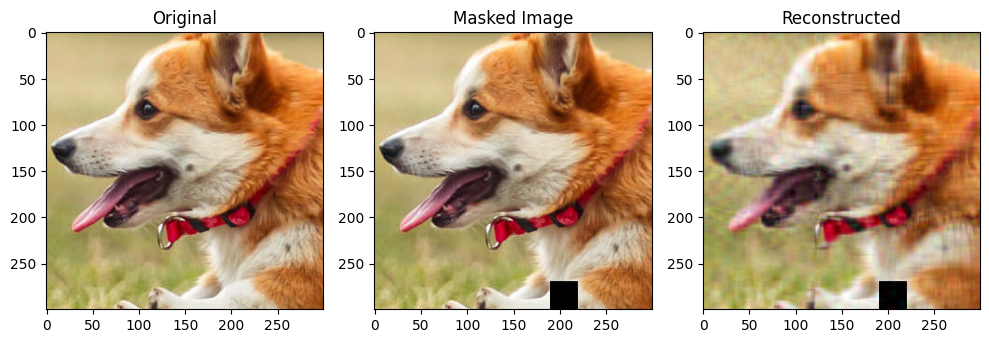

In [283]:
r = 20  # Rank for each channel

# Initialize W and H matrices separately for each channel
Ws = []
Hs = []
for channel in range(masked_image.shape[0]):
    W = torch.randn(masked_image.shape[1], r, requires_grad=True, device=device)
    H = torch.randn(r, masked_image.shape[2], requires_grad=True, device=device)
    Ws.append(W)
    Hs.append(H)

# ... (optimizer and training loop remain the same)
optimizer = torch.optim.Adam(Ws + Hs, lr=learning_rate)
for i in range(num_iterations):
    losses = []
    for channel in range(masked_image.shape[0]):
        loss = torch.norm(torch.mm(Ws[channel], Hs[channel]) - masked_image[channel])
        losses.append(loss)
    loss = sum(losses)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

# Reconstruct the image with 3 channels
reconstructed_channels = []
for channel in range(masked_image.shape[0]):
    reconstructed_channel = torch.mm(Ws[channel], Hs[channel])
    reconstructed_channels.append(reconstructed_channel)
reconstructed_single = torch.stack(reconstructed_channels, dim=0)  # Combine channels
reconstructed_single=rearrange(reconstructed_single,'c h w -> h w c')
# Plot the original and reconstructed images
plot_original_masked_reconstructed_images(crop, masked_image,reconstructed_single, title1="Original", title2="Masked Image", title3="Reconstructed")

torch.Size([300, 20]) torch.Size([20, 300])
Iteration 0, Loss: 4062.031641647139
Iteration 1000, Loss: 55.74949456557495
Iteration 2000, Loss: 43.869373469740665
Iteration 3000, Loss: 39.373163152491585
Iteration 4000, Loss: 37.083507453221415
Iteration 5000, Loss: 36.11166666993409
Iteration 6000, Loss: 35.78846200228254
Iteration 7000, Loss: 35.585651523404024
Iteration 8000, Loss: 35.47776112346065
Iteration 9000, Loss: 35.467303323757804


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


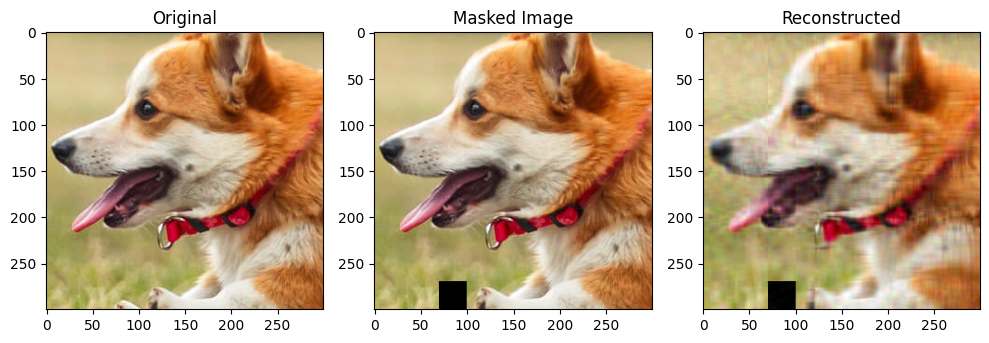

In [285]:
r = 20
W = torch.randn(crop.shape[1], r, requires_grad=True, device=device)
H = torch.randn(r, crop.shape[2], requires_grad=True, device=device)
print(W.shape, H.shape)
r = 20  # Rank for each channel

# Initialize W and H matrices separately for each channel
Ws = []
Hs = []
for channel in range(masked_image_two_channel.shape[0]):
    W = torch.randn(masked_image_two_channel.shape[1], r, requires_grad=True, device=device)
    H = torch.randn(r, masked_image_two_channel.shape[2], requires_grad=True, device=device)
    Ws.append(W)
    Hs.append(H)

# ... (optimizer and training loop remain the same)
optimizer = torch.optim.Adam(Ws + Hs, lr=learning_rate)
for i in range(num_iterations):
    losses = []
    for channel in range(masked_image_two_channel.shape[0]):
        loss = torch.norm(torch.mm(Ws[channel], Hs[channel]) - masked_image_two_channel[channel])
        losses.append(loss)
    loss = sum(losses)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

# Reconstruct the image with 3 channels
reconstructed_channels = []
for channel in range(masked_image_two_channel.shape[0]):
    reconstructed_channel = torch.mm(Ws[channel], Hs[channel])
    reconstructed_channels.append(reconstructed_channel)
reconstructed_two = torch.stack(reconstructed_channels, dim=0)  # Combine channels
reconstructed_two=rearrange(reconstructed_two,'c h w -> h w c')
# Plot the original and reconstructed images
plot_original_masked_reconstructed_images(crop, masked_image_two_channel,reconstructed_two, title1="Original", title2="Masked Image", title3="Reconstructed")

torch.Size([300, 20]) torch.Size([20, 300])
Iteration 0, Loss: 4024.6119957593182
Iteration 1000, Loss: 55.975069800701306
Iteration 2000, Loss: 43.912563837899214
Iteration 3000, Loss: 39.515517112995276
Iteration 4000, Loss: 37.42293837463479
Iteration 5000, Loss: 36.4713087495353
Iteration 6000, Loss: 36.118836156005464
Iteration 7000, Loss: 35.92726059202243
Iteration 8000, Loss: 35.848763685994484
Iteration 9000, Loss: 35.856763885569926


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


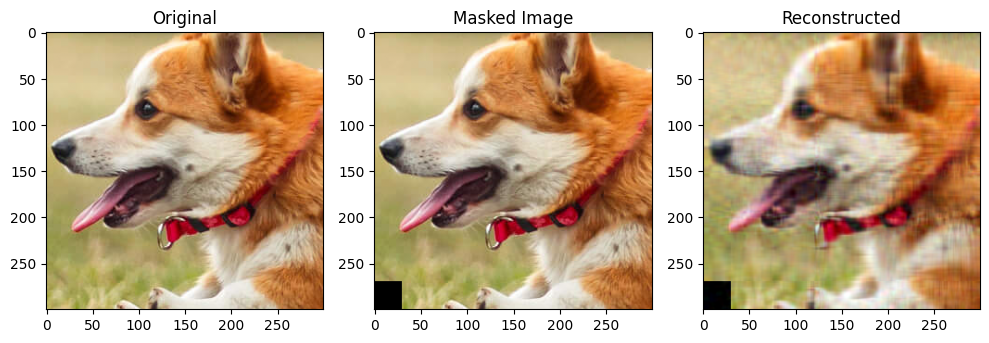

In [287]:
r = 20
W = torch.randn(crop.shape[1], r, requires_grad=True, device=device)
H = torch.randn(r, crop.shape[2], requires_grad=True, device=device)
print(W.shape, H.shape)
r = 20  # Rank for each channel

# Initialize W and H matrices separately for each channel
Ws = []
Hs = []
for channel in range(masked_image_five_channel.shape[0]):
    W = torch.randn(masked_image_five_channel.shape[1], r, requires_grad=True, device=device)
    H = torch.randn(r, masked_image_five_channel.shape[2], requires_grad=True, device=device)
    Ws.append(W)
    Hs.append(H)

# ... (optimizer and training loop remain the same)
optimizer = torch.optim.Adam(Ws + Hs, lr=learning_rate)
for i in range(num_iterations):
    losses = []
    for channel in range(masked_image_five_channel.shape[0]):
        loss = torch.norm(torch.mm(Ws[channel], Hs[channel]) - masked_image_five_channel[channel])
        losses.append(loss)
    loss = sum(losses)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

# Reconstruct the image with 3 channels
reconstructed_channels = []
for channel in range(masked_image_five_channel.shape[0]):
    reconstructed_channel = torch.mm(Ws[channel], Hs[channel])
    reconstructed_channels.append(reconstructed_channel)
reconstructed_five = torch.stack(reconstructed_channels, dim=0)  # Combine channels
reconstructed_five=rearrange(reconstructed_five,'c h w -> h w c')
# Plot the original and reconstructed images
plot_original_masked_reconstructed_images(crop, masked_image_five_channel,reconstructed_five, title1="Original", title2="Masked Image", title3="Reconstructed")

In [289]:
#Compute the following metrics: RMSE on predicted v/s ground truth high resolution image

ground_truth = crop
predicted = rearrange(reconstructed_single, 'h w c -> c h w')
rmse_single = torch.sqrt(torch.mean((ground_truth - predicted) ** 2))
print(f"RMSE: {rmse_single.item()}")
predicted_two = rearrange(reconstructed_two, 'h w c -> c h w')
rmse_two = torch.sqrt(torch.mean((ground_truth - predicted_two) ** 2))
print(f"RMSE: {rmse_two.item()}")
predicted_five = rearrange(reconstructed_five, 'h w c -> c h w')
rmse_five = torch.sqrt(torch.mean((ground_truth - predicted_five) ** 2))
print(f"RMSE: {rmse_five.item()}")


RMSE: 0.09512782878072226
RMSE: 0.07626823931037059
RMSE: 0.07388931270738379


In [290]:
#Peak Signal-to-Noise Ratio (PSNR)
def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

psnr_single = psnr(ground_truth, predicted)
print(f"PSNR: {psnr_single.item()}")
psnr_two = psnr(ground_truth, predicted_two)
print(f"PSNR: {psnr_two.item()}")
psnr_five = psnr(ground_truth, predicted_five)
print(f"PSNR: {psnr_five.item()}")


PSNR: 20.433848311530298
PSNR: 22.35312558792431
PSNR: 22.628367461564945


In [ ]:

def plot_image_with_patch(image, patch_size, x, y, ax, highlight_color="red",mask_color="gray"):
    # Convert image to numpy array and adjust for plotting
    image_np =  rearrange(crop, 'c h w -> h w c').cpu().numpy()

    # Plot the original image on the provided axis
    ax.imshow(image_np)

    # Create a rectangle patch for highlighting
    rect = patches.Rectangle(
        (x, y),
        patch_size,
        patch_size,
        linewidth=2,
        edgecolor=highlight_color,
        facecolor=mask_color
    )

    # Add the patch to the plot
    ax.add_patch(rect)

    ax.set_xlim(0, image_np.shape[1])  # set x-axis limit
    ax.set_ylim(image_np.shape[0], 0)  # set y-axis limit, reversing the direction
    ax.set_title("Image with Patches")

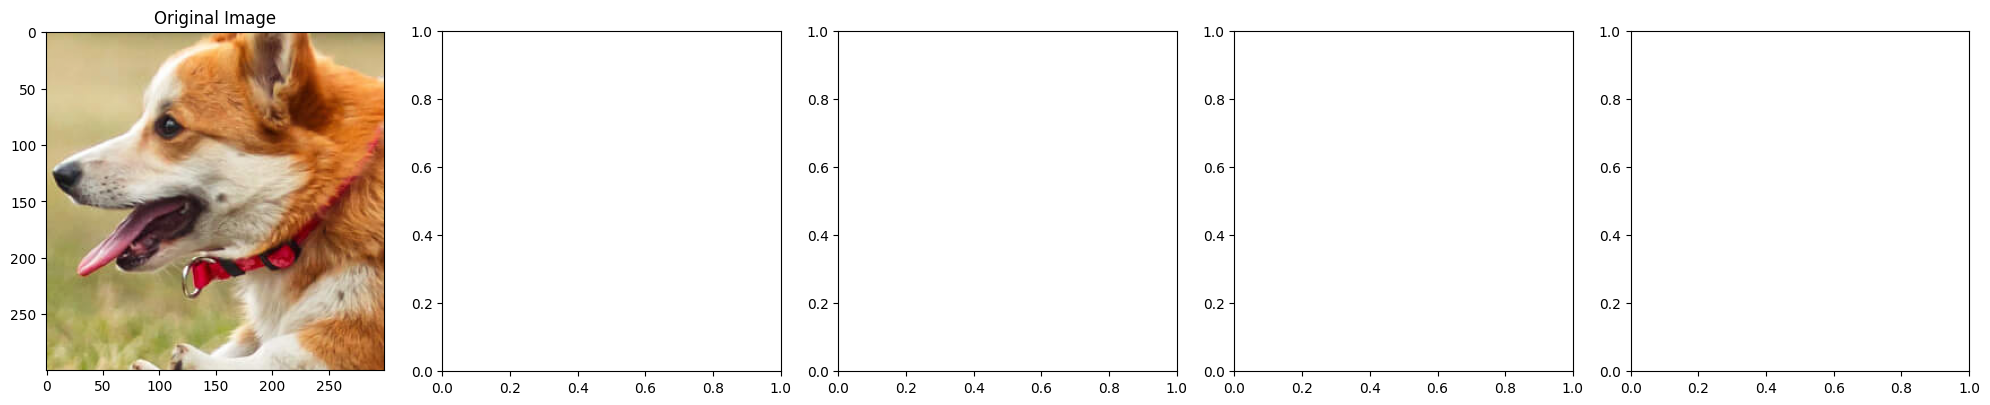

In [ ]:
# Your image and patch parameters
image_shape = (3, 300, 300)
patch_size = 30
min_x = 0
max_x = image.shape[2] - patch_size
min_y = image.shape[1] - patch_size
max_y = 0

# Create a single figure and axis for the big image
fig, ax = plt.subplots()
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

# # Plot the big image once
image_np =  rearrange(crop, 'c h w -> h w c').cpu().numpy()
axs[0].imshow(image_np)
axs[0].set_title("Original Image")
# Iterate over the patches and plot them on the same axis
for y in range(min_y, max_y - 1, -10): 
    for x in range(min_x, max_x, 10):
        if plot_counter >= len(axs):
            break        

        patch = get_patch(image, patch_size, x, y)
        if is_mostly_single_color(patch):
            plot_image_with_patch(image, patch_size, x, y, axs[plot_counter])
            plot_counter+=1
            break

# Show the plot
plt.tight_layout()            
plt.show()


In [ ]:
def has_multiple_channels(patch,threshold=0.1,min_channel=2):
    std_devs_per_channel=torch.std(patch,dim=(1,2))
    return (std_devs_per_channel > threshold).sum()>=min_channel


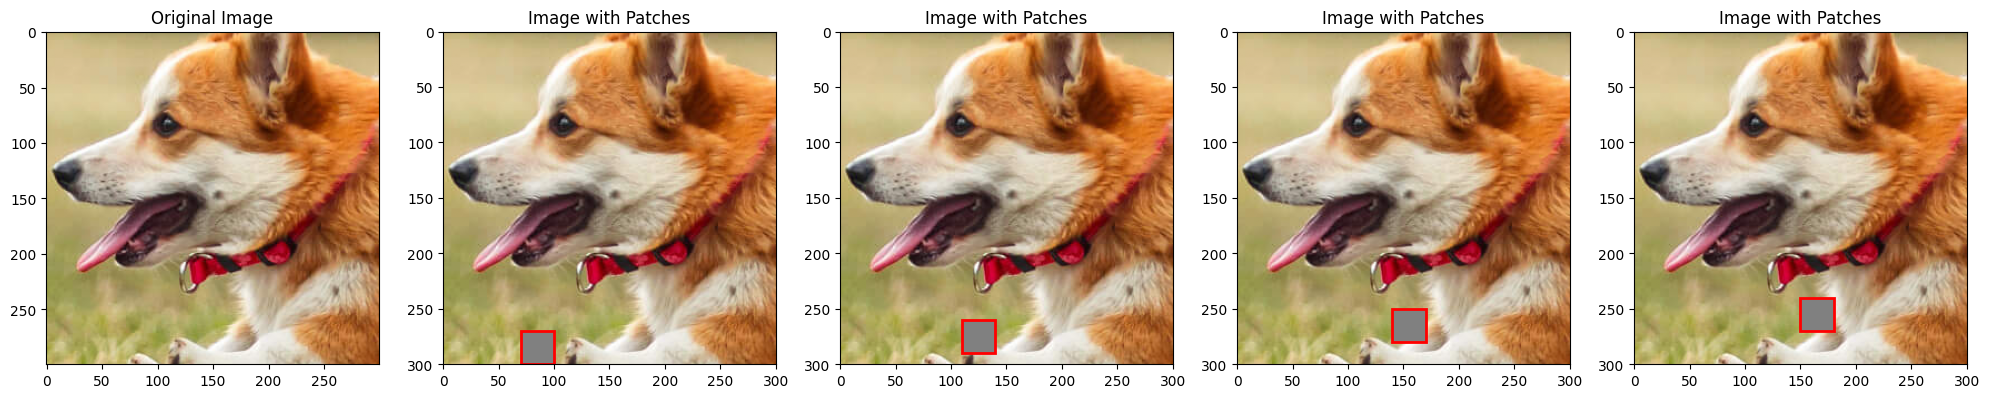

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
plot_counter = 0

axs[0].imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
axs[0].set_title("Original Image")
plot_counter = 1
# Iterate over the patches and plot them on the same axis
for y in range(min_y, max_y - 1, -10): 
    for x in range(min_x, max_x, 10):
        if plot_counter >= len(axs):
            break        

        patch = get_patch(image, patch_size, x, y)
        if has_multiple_channels(patch, threshold=0.1, min_channel=2):
            plot_image_with_patch(image, patch_size, x, y, axs[plot_counter])
            plot_counter += 1
            break

# Show the plot
plt.tight_layout()            
plt.show()


In [ ]:
def has_at_least_n_colors(patch, min_colors=5):
    unique_colors_per_channel = [torch.unique(patch[channel, :, :]).shape[0] for channel in range(patch.shape[0])]
    # print(unique_colors_per_channel)
    # print(unique_colors_per_channel)
    return all(count >= min_colors for count in unique_colors_per_channel)


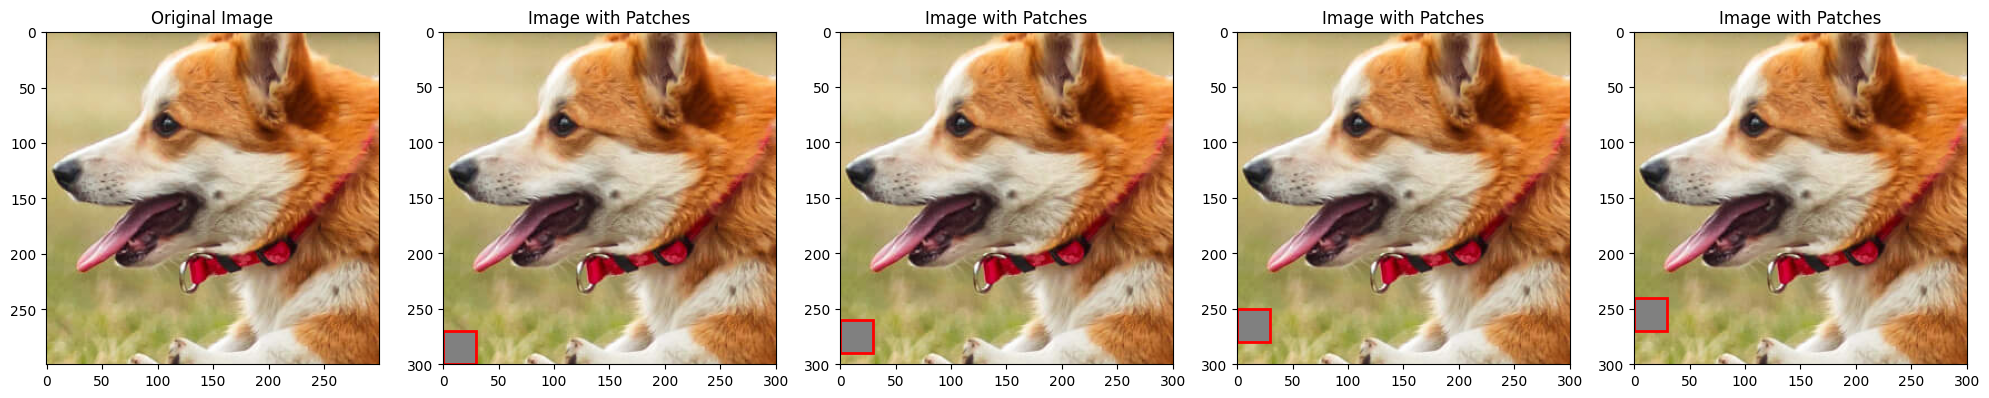

In [ ]:
# fig, ax = plt.subplots()
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
plot_counter = 0

# # Plot the big image once
image_np =  rearrange(crop, 'c h w -> h w c').cpu().numpy()
axs[0].imshow(image_np)
axs[0].set_title("Original Image")
plot_counter = 1
# Iterate over the patches and plot them on the same axis
for y in range(min_y, max_y - 1, -10): 
    for x in range(min_x, max_x, 10):
        if plot_counter >= len(axs):
            break        

        patch = get_patch(image, patch_size, x, y)
        if has_at_least_n_colors(patch, min_colors=5):
            plot_image_with_patch(image, patch_size, x, y, axs[plot_counter])
            plot_counter+=1
            break

# Show the plot
plt.tight_layout()            
plt.show()